In [1]:
import wandb
wandb.login(key="5fb34431b405eb21dc0f263e5b3cf2c15fdc7471")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma24m004 (ma24m004-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
# Define dataset path
dataset_path = "/kaggle/input/dataset/inaturalist_12K"

# Implementation of Strategy (2)
- Freeze early layers (e.g., first 3 blocks of ResNet).
- Unfreeze and fine-tune the last few layers (e.g., last block and final layer).

This gives a balance: model still adapts a bit to the new dataset without needing full retraining.

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder


# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze top k layers (e.g., last 2 ResNet block + fc layer)
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers you want to fine-tune (e.g., layer3, layer2, and the final fc layer)
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

# Modify final layer to match 10 iNaturalist classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)



In [24]:
# Data transforms
transform =transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
 ])


# ✅ Load full train dataset
full_train_dataset = ImageFolder(root=f"{dataset_path}/train", transform=transform)

# ✅ Split train dataset into 80% train and 20% validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [25]:
import wandb
epochs = 5
train_losses = []
val_accuracies = []
# Initialize a WandB project
wandb.init(project="Assignment_2_CNN", config={
    "epochs": epochs,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "model": "ResNet50"
})

# WandB logging
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels)
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Log training loss to WandB
    wandb.log({"training_loss": epoch_loss})

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels)
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Log validation accuracy to WandB
    wandb.log({"validation_accuracy": val_accuracy})

    # Print results per epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Close the WandB run
wandb.finish() 

Epoch 1/5, Loss: 0.8390, Validation Accuracy: 0.7945
Epoch 2/5, Loss: 0.3251, Validation Accuracy: 0.8025
Epoch 3/5, Loss: 0.1564, Validation Accuracy: 0.8015
Epoch 4/5, Loss: 0.1116, Validation Accuracy: 0.7900
Epoch 5/5, Loss: 0.0860, Validation Accuracy: 0.7810


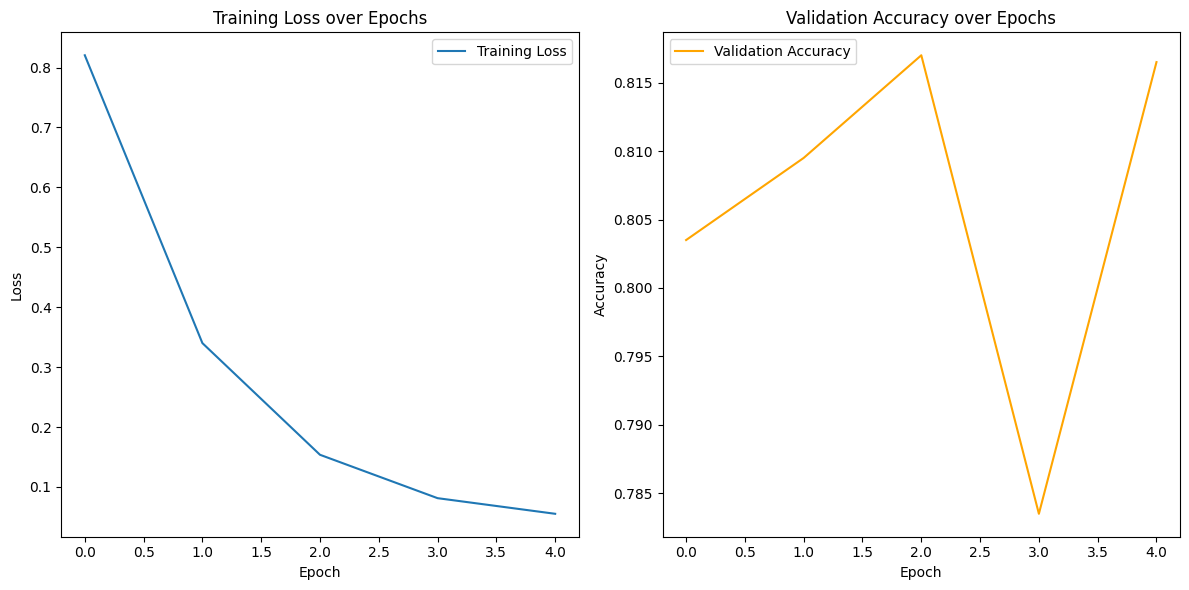

In [6]:
import matplotlib.pyplot as plt
import wandb
import torch  # in case it's needed

# # Optional: Initialize wandb (only do this once at the top of your notebook)
wandb.init(project="Assignment_2_CNN")

# Convert tensors to CPU + NumPy if needed
train_losses = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
val_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in val_accuracies]

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()

# ✅ Log to wandb as an image
wandb.log({"Loss and Accuracy Curve": wandb.Image(plt)})

# Optional: Display it
plt.show()


In [7]:
# Test dataset and dataloader
test_dataset = ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [8]:
# Set model to evaluation mode
model.eval()

# Initialize variables to track predictions
test_correct = 0
test_total = 0
test_loss = 0.0

# Disable gradient calculation (not needed for evaluation)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels)
        test_total += labels.size(0)

# Calculate final test accuracy and average loss
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Log to WandB
wandb.log({
    "test_loss": avg_test_loss,
    "test_accuracy": test_accuracy
})

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.7226
Test Accuracy: 0.8245


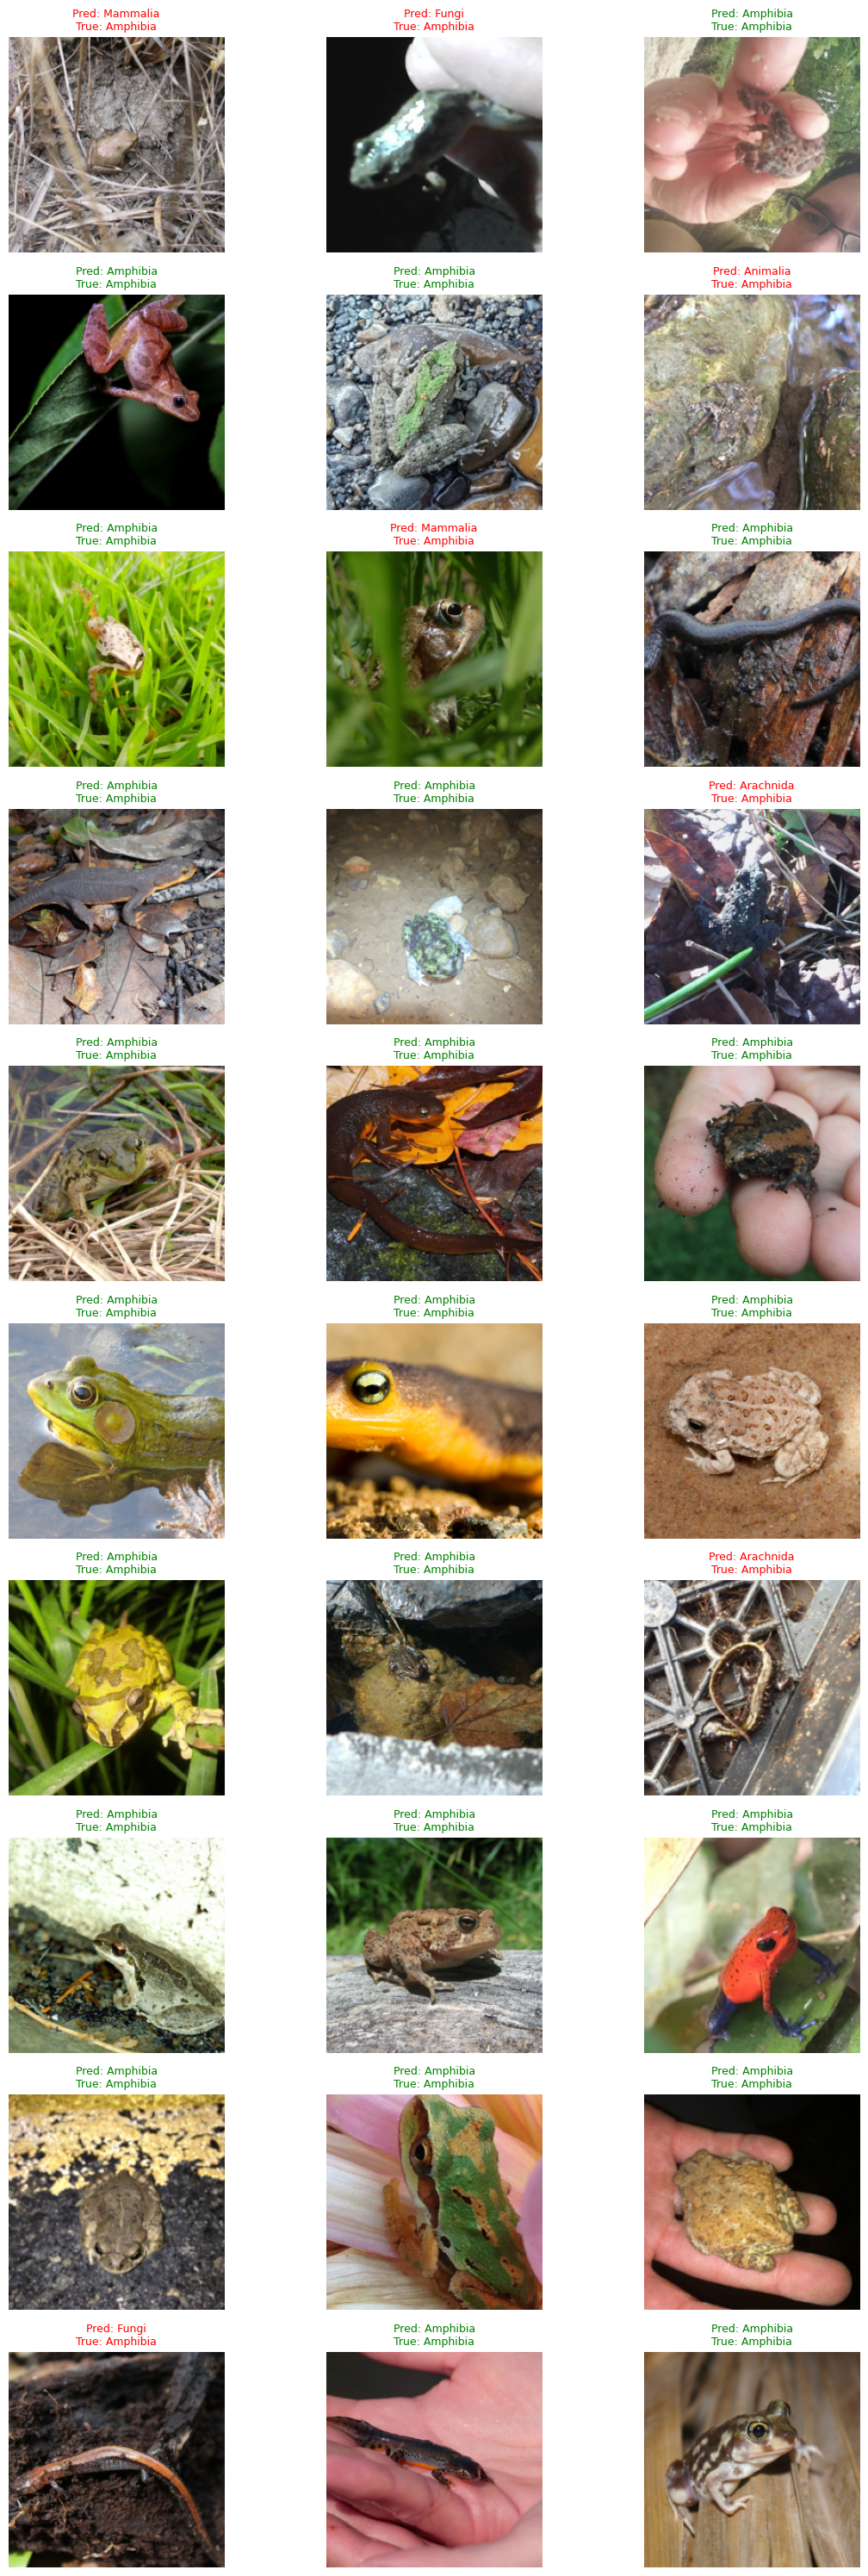

In [28]:
import matplotlib.pyplot as plt
import torchvision
import wandb

# ✅ Initialize WandB (resumes existing run if needed)
wandb.init(project="Assignment_2_CNN", resume=True)

# Set model to eval mode
model.eval()

# Class names
class_names = test_dataset.classes

# Display 30 predictions
images_shown = 30
images_displayed = 0
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
axes = axes.flatten()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            if images_displayed >= images_shown:
                break

            image = inputs[i].cpu()
            label = labels[i].item()
            pred = preds[i].item()

            # Unnormalize the image
            img = image.permute(1, 2, 0).numpy()
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img = img.clip(0, 1)

            ax = axes[images_displayed]
            ax.imshow(img)
            ax.axis("off")

            # Title color based on correctness
            color = "green" if pred == label else "red"
            ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}", color=color, fontsize=9)

            images_displayed += 1

        if images_displayed >= images_shown:
            break

plt.tight_layout()

# ✅ Log the figure to wandb
wandb.log({"Test Predictions Grid": wandb.Image(plt)})

# Show locally
plt.show()
wandb.finish()